In [1]:
# importing libraries
import os, sys
sys.path.append(os.getcwd())

import choropleth_pipeline as cp
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm


In [2]:
VG250_GPKG = "../geometry/DE_VG250.gpkg"
ASC1   = "../data/DWDgrid/HotDays/TADXCDGE30_17_2011_01.asc"  
ASC2   = "../data/DWDgrid/HotDays/TADXCDGE30_17_2022_01.asc" 
ASC3   = "../data/DWDgrid/HotDays/TADXCDGE30_17_2024_01.asc" 

sources = [
    cp.SourceSpec(
        name         = "HotDays2011", 
        path         = ASC1, 
        year         = "2011", 
        fallback_crs = "EPSG:31467"
    ),
    cp.SourceSpec(
        name         = "HotDays2022", 
        path         = ASC2, 
        year         = "2022", 
        fallback_crs = "EPSG:31467"
    ),
    cp.SourceSpec(
        name         = "HotDays2024", 
        path         = ASC3, 
        year         = "2024", 
        fallback_crs = "EPSG:31467"
    ),
]


# Geographie-daten laden
# ARS = Amtlicher Regionalschlüssel
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col = "ARS")


In [6]:
gdf = cp.process_sources(
    sources,
    vg,
    stats=("mean",),
    all_touched=False,
    target_level="GEM"   # Aggregation über Gemeinden
)

gdf.head(5)
# spalte benennen ist nicht notwendig bei mehreren Dateien

,ARS,geometry,HotDays2011_mean,HotDays2022_mean,HotDays2024_mean
0,010010000000,"MULTIPOLYGON (((9.41264 54.82263, 9.41315 54.8...",0.0,5.000000,2.00000
1,010010000000,"MULTIPOLYGON (((9.41264 54.82263, 9.41315 54.8...",0.0,5.000000,NaN
2,010010000000,"MULTIPOLYGON (((9.41264 54.82263, 9.41315 54.8...",0.0,NaN,2.00000
3,010010000000,"MULTIPOLYGON (((9.41264 54.82263, 9.41315 54.8...",0.0,NaN,NaN
4,010020000000,"MULTIPOLYGON (((10.16915 54.43137, 10.16956 54...",0.0,5.108108,2.18018


In [8]:
gdf.rename(columns = {'HotDays2011_mean':'HotDays2011','HotDays2022_mean':'HotDays2022','HotDays2024_mean':'HotDays2024'}, inplace = True)
gdf.head(5)

gdf[['HotDays2011', 'HotDays2022', 'HotDays2024']].max()

HotDays2011    19.258065
HotDays2022    46.684211
HotDays2024    30.500000
dtype: float64

In [10]:
# laender laden für outlines
laender = cp.load_level(vg, level = "LAN")
# kreise = cp.load_level(vg, level = 'KRS')

# länder und kreise vereinen
# r = laender.overlay(kreise, how='union')

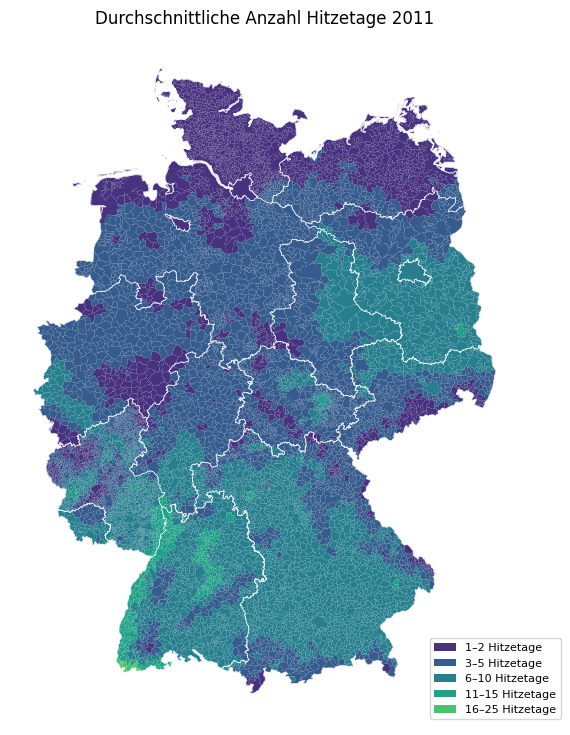

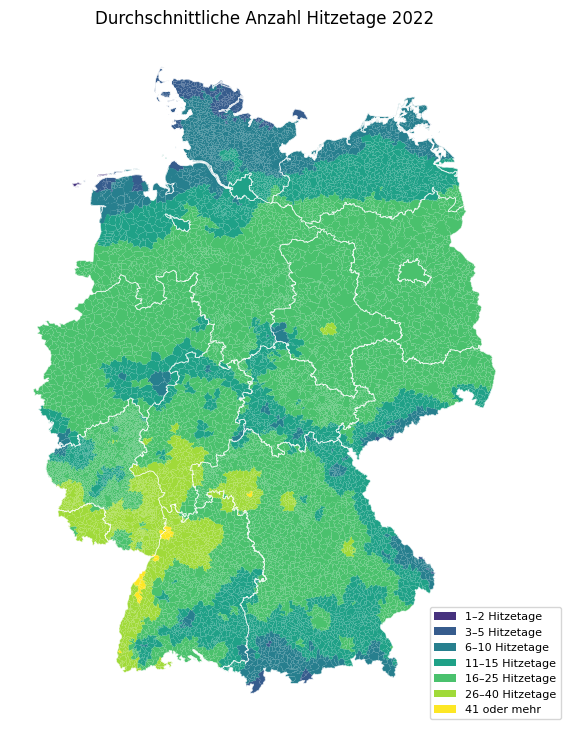

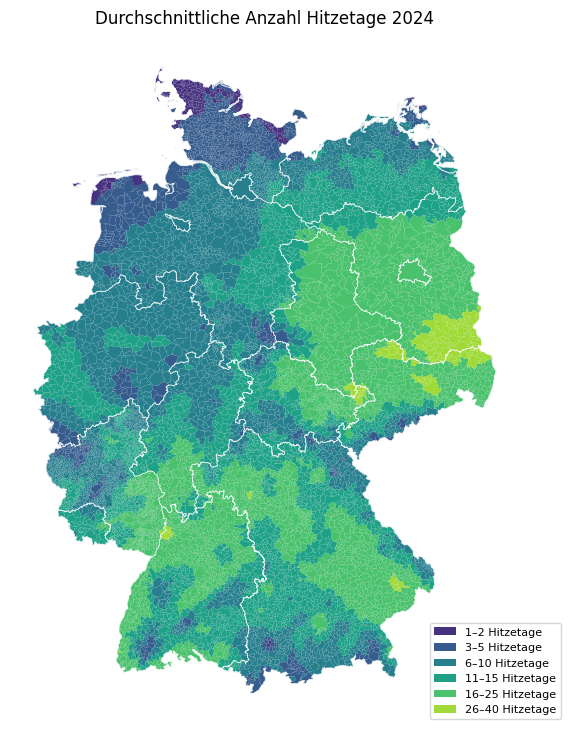

In [12]:
bins = (-float("inf"), 0, 2, 5, 10, 15, 25, 40, float("inf"))
labels = (
    "0 Hitzetage",
    "1–2 Hitzetage",
    "3–5 Hitzetage",
    "6–10 Hitzetage",
    "11–15 Hitzetage",
    "16–25 Hitzetage",
    "26–40 Hitzetage",
    "41 oder mehr"
)

# YlOrRd-ähnlich, hell (wenig) → dunkel (viel)
colors = [
    "#FFFFCC",
    "#FFEDA0",
    "#FED976",
    "#FEB24C",
    "#FD8D3C",
    "#FC4E2A",
    "#E31A1C",
    "#B10026",
]


for year in ['2011', '2022', '2024']:
    # fig, ax = cp.plot_choropleth_continuous(
    #     gdf,
    #     f'HotDays{year}',
    #     cmap_name="Reds",
    #     laender = laender,
    #     title=f'Durchschnittliche Anzahl Hitzetage {year}',
    #     norm=TwoSlopeNorm(vmin=0, vcenter=25, vmax=50),
    # )
    fig, ax = cp.plot_choropleth_discrete(
        gdf,
        f'HotDays{year}',
        bins = bins,
        labels = labels,
        laender = laender,
        title=f'Durchschnittliche Anzahl Hitzetage {year}',
    )
    
    cp.save_map(fig, filename=f"Hitzetage_{year}.png", out_dir="exports", dpi=300)

In [16]:
gdf.columns

Index(['ARS', 'geometry', 'HotDays2011', 'HotDays2022', 'HotDays2024'], dtype='object')

In [17]:
gdf['Delta'] = gdf['HotDays2022']-gdf['HotDays2011']

'exports\\Aenderung_Hitzetage_2011_2022.png'

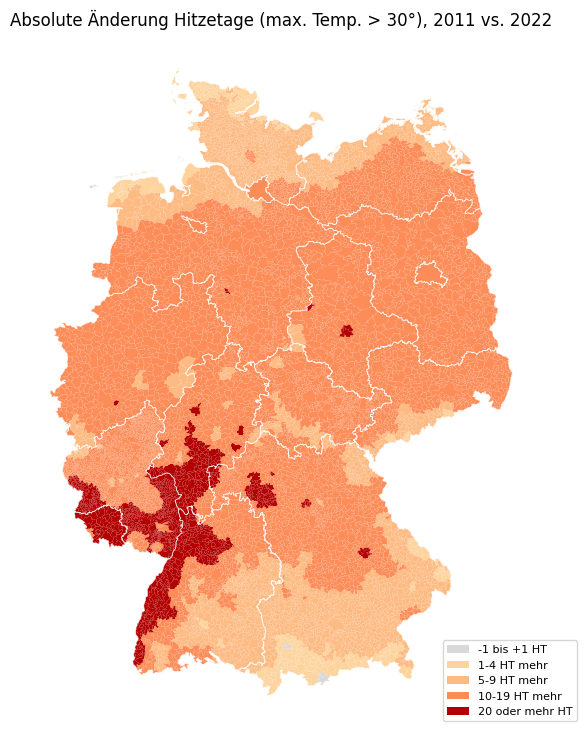

In [18]:
bins = (-float("inf"), -10, -5, -1, 1, 5, 10, 20, float("inf"))

labels = (
    "mehr als 10 HT weniger",
    "5-9 HT weniger",
    "1-4 HT weniger",
    "-1 bis +1 HT",
    "1-4 HT mehr",
    "5-9 HT mehr",
    "10-19 HT mehr",
    "20 oder mehr HT"
)

gdf = cp.classify_discrete(
    gdf,
    'Delta',
    bins=bins, 
    labels=labels, 
    class_col="dmi_class"
)

colors = [
    "#084081",  # mehr als 10 HT weniger
    "#2B8CBE",  # 5-9 HT weniger
    "#A6BDDB",  # 1-4 HT weniger
    "#D9D9D9",  # -1 bis +1 HT (≈ keine Änderung) -> neutral Grau
    "#FDD49E",  # 1-4 HT mehr
    "#FDBB84",  # 5-9 HT mehr
    "#FC8D59",  # 10-19 HT mehr
    "#B30000",  # 20 oder mehr HT
]

fig, ax = cp.plot_choropleth_discrete(
    gdf, 
    'Delta',
    bins=bins,
    labels=labels,
    laender=laender,
    colors=colors,
    title= "Absolute Änderung Hitzetage (max. Temp. > 30°), 2011 vs. 2022"
)

cp.save_map(fig, filename="Aenderung_Hitzetage_2011_2022.png", out_dir="exports", dpi=300)

In [3]:
VG250_GPKG = "../geometry/DE_VG250.gpkg"
ASC1   = "../data/DWDgrid/HotDays/TADXCDGE30_17_2011_01.asc"  
ASC2   = "../data/DWDgrid/HotDays/TADXCDGE30_17_2022_01.asc" 
ASC3   = "../data/DWDgrid/HotDays/TADXCDGE30_17_2024_01.asc" 

sources = [
    cp.SourceSpec(
        name         = "HotDays2011", 
        path         = ASC1, 
        year         = "2011", 
        fallback_crs = "EPSG:31467"
    ),
    cp.SourceSpec(
        name         = "HotDays2022", 
        path         = ASC2, 
        year         = "2022", 
        fallback_crs = "EPSG:31467"
    ),
    cp.SourceSpec(
        name         = "HotDays2024", 
        path         = ASC3, 
        year         = "2024", 
        fallback_crs = "EPSG:31467"
    ),
]


# Geographie-daten laden
# ARS = Amtlicher Regionalschlüssel
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col = "ARS")

gdf = cp.process_sources(
    sources,
    vg,
    stats=("mean",),
    all_touched=False,
    target_level="GEM"   # Aggregation über Gemeinden
)


In [4]:
print(gdf.columns)
print(gdf.shape)

Index(['ARS', 'geometry', 'HotDays2011_mean', 'HotDays2022_mean',
       'HotDays2024_mean'],
      dtype='object')
(10957, 5)


In [5]:
heat = gdf.drop(columns = 'geometry').copy()

In [6]:
heat.columns

Index(['ARS', 'HotDays2011_mean', 'HotDays2022_mean', 'HotDays2024_mean'], dtype='object')

In [7]:
heat.to_csv('HotDays.csv', index = False)

In [9]:
geom = gdf[['ARS','geometry']].copy()

In [8]:
heat.shape

(10957, 4)